# stochastic analysis of COVID19 time series in "Baden-Württemberg"
data as of 10.06.2020 by https://sozialministerium.baden-wuerttemberg.de/de/gesundheit-pflege/gesundheitsschutz/infektionsschutz-hygiene/informationen-zu-coronavirus/lage-in-baden-wuerttemberg/

algorithm from "Analysis of time series from stochastic processes" by J.Gradisek, S.Riegert, R.Freidrich, I.Grabec [1]

In [43]:
import pandas as pd
import numpy as np
from scipy import signal, stats, integrate
import matplotlib.pyplot as plt
import datetime

## 1. extract values from selected list
variables names: *I: Infected; *T: Deceased

In [2]:
filename = 'Tabelle_Coronavirus-Faelle-BW.xlsx'
dfi = pd.read_excel(filename, sheet_name='Infizierte Coronavirus in BW', header=None)
dft = pd.read_excel(filename, sheet_name='Todesfälle Coronavirus in BW', header=None)

In [3]:
ctyI = np.nan_to_num(np.asarray(dfi))
ctyT = np.nan_to_num(np.asarray(dft))
# row 7: dates
# row 8 to 51: regions
    # row 18: Freiburg
    # row 38: Ravensburg
# row 52: sum

### plot regional data

In [4]:
index = 17
region = ctyI[index][0]
title = 'Corona cases in %s' % region

# calculate x data: dates
# currently: approximation where each month is approximated by 30 days.
xI = [el.day+el.month*30 if type(el) == datetime.datetime else False for el in ctyI[6]]
xT = [el.day+el.month*30 if type(el) == datetime.datetime else False for el in ctyT[6]]

# calculate trajectory points from data of given index
yI = [el if type(el) == int else False for el in ctyI[index]]
yT = [el if type(el) == int else False for el in ctyT[index]]

# remove first element of lists (column of regions, only str in these)
del xI[0]
del xT[0]
del yI[0]
del yT[0]

# flip arrays
xI = np.flip(xI)
xT = np.flip(xT)
yI = np.flip(yI)
yT = np.flip(yT)

# Calculate new cases per day
dyIdt = np.diff(yI, prepend=0)
    
# Calculate new deaths per day
dyTdt = np.diff(yT,prepend=0)

# Checking for mistakes
print('I1:', len(xI) == len(yI))
print('T1:', len(xT) == len(yT))
print('dIdt:', len(xI) == len(dyIdt))
print('dTdt:', len(xT) == len(dyTdt))
checksum = 0
for el in dyIdt:
    checksum += el
print("checksum I:", checksum == yI[-1])
checksum = 0
for el in dyTdt:
    checksum += el
print("checksum T:", checksum == yT[-1])

I1: True
T1: True
dIdt: True
dTdt: True
checksum I: True
checksum T: True


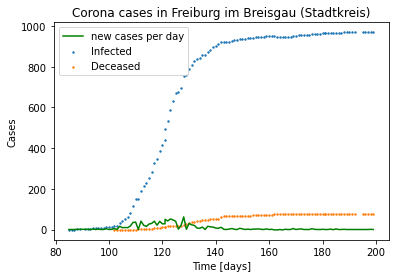

In [5]:
# Plot infected, deceased and new cases per day
plt.scatter(xI, yI, label='Infected', s=2)
plt.scatter(xT, yT, label='Deceased', s=2)
plt.plot(xI, dyIdt, label='new cases per day', c='g')
plt.xlabel('Time [days]')
plt.ylabel('Cases')
plt.title(title)
plt.legend(loc='upper left')
plt.show()
#plt.savefig('%sCases.png' % region)

### plot total data

In [6]:
# calculation of x-data in cell above

# calculate total sum
yI_total = [el for el in ctyI[51]]
yT_total = [el for el in ctyT[51]]

# remove first element of lists (column of regions, only str in these)
del yI_total[0]
del yT_total[0]

# flip arrays
yI_total = np.flip(yI_total)
yT_total = np.flip(yT_total)

# Calculate new cases per day
dyI_totaldt = np.diff(yI_total, prepend=0)
    
# Calculate new deaths per day
dyT_totaldt = np.diff(yT_total, prepend=0)
    
# Checking for mistakes
print('I2:', len(xI) == len(yI_total))
print('T2:', len(xT) == len(yT_total))
print('dI_totaldt:', len(xI) == len(dyI_totaldt))
print('dT_totaldt:', len(xT) == len(dyT_totaldt))
checksum = 0
for el in dyI_totaldt:
    checksum += el
print("checksum I:", checksum == yI_total[-1])
checksum = 0
for el in dyT_totaldt:
    checksum += el
print("checksum T:", checksum == yT_total[-1])

I2: True
T2: True
dI_totaldt: True
dT_totaldt: True
checksum I: True
checksum T: True


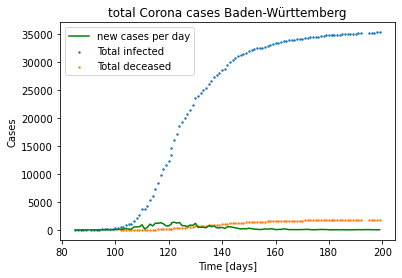

In [7]:
# Plot infected, deceased and new cases per day
plt.scatter(xI, yI_total, label='Total infected', s=2)
plt.scatter(xT, yT_total, label='Total deceased', s=2)
plt.plot(xI, dyI_totaldt, label='new cases per day', c='g')
plt.xlabel('Time [days]')
plt.ylabel('Cases')
plt.title('total Corona cases Baden-Württemberg')
plt.legend(loc='upper left')
plt.show()
#plt.savefig('BWCases.png')

## 2. stochastic analysis

### conditional probability function

In [142]:
class Probability:
    def __init__(self, saving=True):
        '''Collective of in this scope used probability functions
        
        Properties:
            - (bool) saving: Defines wheter results should be saved or not.
                If used, it'll reduce runtime.
        '''
        self.saving = saving
        self.saved = {}
        
    def reset_saved(self, specific=False, all=True):
        '''Resets specific or all saved values in self.saved.
        
        Parameters:
            - (list) specific: If set all list elements which are also
                represented in self.saved will be removed.
            - (bool) all: If True all entries in self.saved will be deleted.
        '''
        if (specific):
            for el in specific:
                del self.saved[el]
        elif (all):
            self.saved = {}
    
    def P_x(self, x):
        '''Probability Distribution
    
        Returns the probability for x having the value x_val.
    
        Parameters:
            - (float) x: The value to search for.
        
        Inherited as P_x(y, t) from [2].
        
        ______________________________________________________________________________
        As for test purposes this function returns a gaussian distribution as default.
        '''
        mu = 0 # mean deviation
        sigma = 0.1 # standard deviation
        size = 1000
        s = np.random.normal(mu, sigma, size)

        # Save distribution if it is intended.
        #self.saved['P_x'] = s if self.saving else None
            
        return s
    
    def P_1(self, y, y_val, t):
        '''Probability Distribution function
        inherited from (9.54)[2]
    
        Calculates the probability distribution for y having the value y_val.
        at time t.
    
        Parameters:
            - (np.array) y: time series.
            - (float) y_val: the value y shall have at time t.
            - (int) t: time to be examined.
        '''
        if (y_val - y[t] == 0):
            return P_x(y, y_val)
        else:
            return 0

    def P_comp(self, y, y_val, t):
        '''Compound Probability function
        inherited from (9.55)[2]
    
        Parameters:
            - (np.array) y: time series.
            - (np.array) y_val: values y shall have at times t.
            - (np.array) t: times.
        
        Requirements:
            >>> len(y_val) == len(t)
        '''
        print(len(y_val), len(t))
        if (len(y_val) != len(t)):
            raise TypeError("y_val and t must have the same size.")
    
        result = 0
        r = True
        for i in range(len(y_val)):
            if (y_val[i] - y[t[i]] != 0):
                r = False
                break;
            else:
                result += self.P_x(y)[y_val[i]]
            
        return result if r else 0

    def P_cond(self, y, y_val, t, y_val_, t_):
        '''Conditional Probabilty function
        inherited from (9.58)[2]
    
        Conditional Probability is the probability-density for Y having at time t_2 the value y_2
        when at time t_1 the value y_1 was present.
        '''
        denominator = self.P_comp(y, y_val, t)
        nominator = self.P_comp(y, y_val_, t_)
    
        result = nominator / denominator
        return result

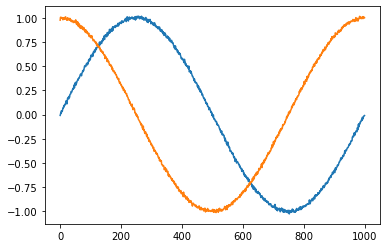

In [143]:
#Creating noised HO data
epsilon = 10e-3
tau = 1000
r = np.linspace(0, 2*np.pi, num=tau)
x = [np.sin(t) + np.random.randn() * epsilon for t in r]
v = [np.cos(t) + np.random.randn() * epsilon for t in r]
plt.clf()
plt.plot(x)
plt.plot(v)
plt.show()

### determine drift- and diffusion-coefficients

In [148]:
def T_1(series, x, t, i, tau):
    p = Probability()
    
    #where does y come from?
    
    y_i = y[i]
    x_i = x[i]
    
    t_ = [el + tau for el in t]
    
    integrand = lambda y: (y_i - x_i) * p.P_cond(series, [y], t_, x, t)
    integratum = integrate.quad(integrand, -np.inf, np.inf) #über y wird integriert
    result = (1 / tau) * integratum
    return result

In [149]:
# Testing T and D

i = 1
t = [0]
series = x
tau = 1
T_1(series, x, t, i, tau)

1 1
1000 1


TypeError: y_val and t must have the same size.

### resulting Fokker-Planck equation

## literature

[1] "Analysis of time series from stochastic processes" by J.Gradisek, S.Riegert, R.Freidrich, I.Grabec

[2] "Simulation - Advanced Topics" by A.Greiner as of June 11, 2020